In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split

In [210]:
class DataLoader:
    def __init__(self, train_path, test_path):
        self.train_data = pd.read_csv(train_path)
        self.test_data = pd.read_csv(test_path)
        self.train_data_cols = self.train_data.columns

    def print_data_info(self):
        print(f"No of training samples: {len(self.train_data)}")
        print(f"No of test samples: {len(self.test_data)}")
        print(f"No of features: {self.train_data.shape[1] - 1}")

    def get_target_column(self):
        target_col = [col for col in self.train_data_cols if col.lower().startswith('class')]
        if len(target_col) == 0:
            print("No target column ")
        else:
            target_col = target_col[0]
            print(f"Target column: {target_col}")
            return target_col

    def split_data(self, target_col):
        self.X_train = self.train_data.drop(target_col, axis=1)
        self.y_train = self.train_data[target_col]
        self.X_test = self.test_data.drop(target_col, axis=1)
        self.y_test = self.test_data[target_col]

In [211]:
class Datafeature:
    def __init__(self, X_train, y_train, X_test, y_test, train_data):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.train_data = train_data

    def encode_labels(self):
        le = LabelEncoder()
        self.y_train = le.fit_transform(self.y_train)
        self.y_test = le.transform(self.y_test)

    def print_class_distribution(self):
        print(f"Class distribution (train data): \n{pd.Series(self.y_train).value_counts()}")

    def visualize_class_distribution(self, target_col):
        plt.figure(figsize=(10, 6))
        sns.countplot(data=self.train_data, x=target_col)
        plt.title(f'Class Distribution (Train Data)')
        plt.show()

    def check_missing_values(self):
        print(f"Missing values train data:\n{self.X_train.isnull().sum()}")
        print(f"Missing values test data:\n{self.X_test.isnull().sum()}")

    def plot_correlation_matrix(self):
        plt.figure(figsize=(12, 10))
        sns.heatmap(self.X_train.corr(), annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix Features')
        plt.show()

    def oversample_smote(self):
        smote = SMOTE()
        self.X_train_sm, self.y_train_sm = smote.fit_resample(self.X_train, self.y_train)
        print(f"Class distribution after SMOTE oversampling:\n{pd.Series(self.y_train_sm).value_counts()}")

    def visualize_smote_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.countplot(x=self.y_train_sm)
        plt.title('Class Distribution in Train Data after SMOTE')
        plt.show()

    def print_numerical_statistics(self):
        print("Numerical Features:")
        print(self.X_train.describe())

    def visualize_numerical_distributions(self):
        plt.figure(figsize=(16, 10))
        num_features = len(self.X_train.columns)
        num_rows = (num_features + 3 - 1) // 3
        for i, col in enumerate(self.X_train.columns):
            plt.subplot(num_rows, 3, i+1)
            sns.histplot(data=self.X_train, x=col, kde=True)
            plt.title(col)
        plt.tight_layout()
        plt.show()

    def visualize_original_scatter(self, target_col):
        plt.figure(figsize=(12, 10))
        plt.scatter(self.train_data.iloc[:, :-1].values[:, 0], self.train_data.iloc[:, :-1].values[:, 1], c=self.y_train, cmap='viridis', alpha=0.5)
        plt.title('Scatter Plot - Features')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.colorbar()
        plt.show()

    def scale_data(self):
        scaler = StandardScaler()
        self.X_train_scaled = scaler.fit_transform(self.X_train)
        self.X_test_scaled = scaler.transform(self.X_test)

    def augment_data(self):
        noise = np.random.normal(0, 0.1, self.X_train_scaled.shape)
        self.X_train_aug = self.X_train_scaled + noise

    def remove_outliers(self):
        outlier_detector = EllipticEnvelope(contamination=0.1)
        outlier_detector.fit(self.X_train_aug)
        outlier_mask = outlier_detector.predict(self.X_train_aug) == 1
        self.X_train_clean = self.X_train_aug[outlier_mask]
        self.y_train_clean = self.y_train[outlier_mask]

    def polynomial_features(self):
        poly = PolynomialFeatures(degree=2, include_bias=False)
        self.X_train_poly = poly.fit_transform(self.X_train_sm)
        self.X_test_poly = poly.transform(self.X_test)

    def select_features(self):
        mutual_info = mutual_info_classif(self.X_train_scaled, self.y_train)
        feature_scores = pd.Series(mutual_info, index=self.X_train.columns)
        selected_features = feature_scores.nlargest(8).index
        self.X_train_selected = self.X_train_scaled[:, [self.X_train.columns.get_loc(f) for f in selected_features]]
        self.X_test_selected = self.X_test_scaled[:, [self.X_test.columns.get_loc(f) for f in selected_features]]

    def encode_categorical_features(self):
        encoder = FeatureHasher(n_features=2**12, input_type='string')
        self.X_train_categorical = encoder.transform(self.y_train.astype(str).reshape(-1, 1))
        self.X_test_categorical = encoder.transform(self.y_test.astype(str).reshape(-1, 1))
        self.X_train_selected = np.hstack([self.X_train_selected, self.X_train_categorical.toarray()])
        self.X_test_selected = np.hstack([self.X_test_selected, self.X_test_categorical.toarray()])

    def apply_pca(self):
        pca = PCA(n_components=0.94)
        self.X_train_pca = pca.fit_transform(self.X_train_selected)
        self.X_test_pca = pca.transform(self.X_test_selected)

    def visualize_cleaned_scatter(self):
        plt.figure(figsize=(12, 10))
        plt.scatter(self.X_train_clean[:, 0], self.X_train_clean[:, 1], c=self.y_train_clean, cmap='viridis', alpha=0.5)
        plt.title('Scatter Plot-Cleaned Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.colorbar()
        plt.show()

    def visualize_pca_scatter(self):
        plt.figure(figsize=(12, 10))
        plt.scatter(self.X_train_pca[:, 0], self.X_train_pca[:, 1], c=self.y_train, cmap='viridis', alpha=0.5)
        plt.title('Scatter Plot-PCA')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar()
        plt.show()

In [212]:
class TrivialSystem:
    def __init__(self, y_train, y_test):
        self.y_train = y_train
        self.y_test = y_test

    def predict(self):
        class_counts = np.bincount(self.y_train)
        class_probs = class_counts / len(self.y_train)
        self.y_trivial = np.random.choice(np.unique(self.y_train), size=len(self.y_test), p=class_probs)
        self.y_train_trivial = np.random.choice(np.unique(self.y_train), size=len(self.y_train), p=class_probs)

    def evaluate_train(self):
        print("\nTraining- Trivial System:")
        print(f"Accuracy: {accuracy_score(self.y_train, self.y_train_trivial):.3f}")
        print(f"Macroaveraged F1 score: {f1_score(self.y_train, self.y_train_trivial, average='macro'):.3f}")
        print(f"Microaveraged F1 score: {f1_score(self.y_train, self.y_train_trivial, average='micro'):.3f}")

In [213]:
class BaselineSystem:
    def __init__(self, X_train_pca, y_train):
        self.X_train_pca = X_train_pca
        self.y_train = y_train

    def split_data(self, test_size=0.2, random_state=42):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
        self.X_train_pca, self.y_train, test_size=test_size, random_state=random_state)

    def train(self):
        self.clf = NearestCentroid()
        self.clf.fit(self.X_train, self.y_train)

    def predict_train(self):
        self.y_train_baseline = self.clf.predict(self.X_train)

    def evaluate_train(self):
        print("\nTraining- Baseline :")
        print(f"Accuracy: {accuracy_score(self.y_train, self.y_train_baseline):.3f}")
        print(f"Macroavg F1score: {f1_score(self.y_train, self.y_train_baseline, average='macro'):.3f}")
        print(f"Microavg F1score: {f1_score(self.y_train, self.y_train_baseline, average='micro'):.3f}")

    def predict_val(self):
        self.y_val_baseline = self.clf.predict(self.X_val)

    def evaluate_val(self):
        print("\nValidation- Baseline :")
        print(f"Accuracy: {accuracy_score(self.y_val, self.y_val_baseline):.3f}")
        print(f"Macroavg F1score: {f1_score(self.y_val, self.y_val_baseline, average='macro'):.3f}")
        print(f"Microavg F1score: {f1_score(self.y_val, self.y_val_baseline, average='micro'):.3f}")

    def predict_test(self, X_test_pca):
        self.y_baseline = self.clf.predict(X_test_pca)
        return self.y_baseline


In [214]:
class ArtificialNeuralNetwork:
    def __init__(self, X_train_pca, y_train):
        self.X_train_pca = X_train_pca
        self.y_train = y_train

    def split_data(self, test_size=0.2, random_state=42):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
        self.X_train_pca, self.y_train, test_size=test_size, random_state=random_state)

    def train(self):
        self.mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
        self.mlp.fit(self.X_train, self.y_train)

    def predict_train(self):
        self.y_train_mlp = self.mlp.predict(self.X_train)

    def evaluate_train(self):
        print("\nTraining- ANN:")
        print(f"Accuracy: {accuracy_score(self.y_train, self.y_train_mlp):.3f}")
        print(f"Macroavg F1score: {f1_score(self.y_train, self.y_train_mlp, average='macro'):.3f}")
        print(f"Microavg F1score: {f1_score(self.y_train, self.y_train_mlp, average='micro'):.3f}")

    def predict_val(self):
        self.y_val_mlp = self.mlp.predict(self.X_val)

    def evaluate_val(self):
        print("\nValidation- ANN:")
        print(f"Accuracy: {accuracy_score(self.y_val, self.y_val_mlp):.3f}")
        print(f"Macro-avg F1score: {f1_score(self.y_val, self.y_val_mlp, average='macro'):.3f}")
        print(f"Micro-avg F1score: {f1_score(self.y_val, self.y_val_mlp, average='micro'):.3f}")

    def predict_test(self, X_test_pca):
        self.y_mlp = self.mlp.predict(X_test_pca)
        return self.y_mlp

In [215]:
class RandomForestClassifier:
    def __init__(self, X_train_pca, y_train):
        self.X_train_pca = X_train_pca
        self.y_train = y_train

    def split_data(self, test_size=0.2, random_state=42):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train_pca, self.y_train, test_size=test_size, random_state=random_state
        )

    def train(self):
        self.rf = SklearnRandomForestClassifier(n_estimators=150, max_depth=10, min_samples_leaf=5)
        self.rf.fit(self.X_train, self.y_train)

    def predict_train(self):
        self.y_train_rf = self.rf.predict(self.X_train)

    def evaluate_train(self):
        print("\nTraining- Random Forest:")
        print(f"Accuracy: {accuracy_score(self.y_train, self.y_train_rf):.3f}")
        print(f"Macroavg F1score: {f1_score(self.y_train, self.y_train_rf, average='macro'):.3f}")
        print(f"Microavg F1score: {f1_score(self.y_train, self.y_train_rf, average='micro'):.3f}")

    def predict_val(self):
        self.y_val_rf = self.rf.predict(self.X_val)

    def evaluate_val(self):
        print("\nValidation- Random Forest:")
        print(f"Accuracy: {accuracy_score(self.y_val, self.y_val_rf):.3f}")
        print(f"Macroavg F1score: {f1_score(self.y_val, self.y_val_rf, average='macro'):.3f}")
        print(f"Microavg F1score: {f1_score(self.y_val, self.y_val_rf, average='micro'):.3f}")

    def predict_test(self, X_test_pca):
        self.y_rf = self.rf.predict(X_test_pca)
        return self.y_rf

In [216]:
class KNearestNeighborsClassifier:
    def __init__(self, X_train_pca, y_train):
        self.X_train_pca = X_train_pca
        self.y_train = y_train

    def split_data(self, test_size=0.2, random_state=42):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train_pca, self.y_train, test_size=test_size, random_state=random_state
        )

    def train(self):
        self.knn = KNeighborsClassifier(n_neighbors=5)
        self.knn.fit(self.X_train, self.y_train)

    def predict_train(self):
        self.y_train_knn = self.knn.predict(self.X_train)

    def evaluate_train(self):
        print("\nTraining-  KNearest Neighbors:")
        print(f"Accuracy: {accuracy_score(self.y_train, self.y_train_knn):.3f}")
        print(f"Macroavg F1score: {f1_score(self.y_train, self.y_train_knn, average='macro'):.3f}")
        print(f"Microavg F1score: {f1_score(self.y_train, self.y_train_knn, average='micro'):.3f}")

    def predict_val(self):
        self.y_val_knn = self.knn.predict(self.X_val)

    def evaluate_val(self):
        print("\nValidation-  KNearest Neighbors:")
        print(f"Accuracy: {accuracy_score(self.y_val, self.y_val_knn):.3f}")
        print(f"Macroavg F1score: {f1_score(self.y_val, self.y_val_knn, average='macro'):.3f}")
        print(f"Microavg F1score: {f1_score(self.y_val, self.y_val_knn, average='micro'):.3f}")

    def predict_test(self, X_test_pca):
        self.y_knn = self.knn.predict(X_test_pca)
        return self.y_knn

In [217]:
class SupportVectorMachine:
    def __init__(self, X_train_pca, y_train):
        self.X_train_pca = X_train_pca
        self.y_train = y_train

    def split_data(self, test_size=0.2, random_state=42):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train_pca, self.y_train, test_size=test_size, random_state=random_state
        )

    def train(self):
        self.svc = SVC(kernel='rbf', gamma='auto') 
        self.svc.fit(self.X_train, self.y_train)

    def predict_train(self):
        self.y_train_svm = self.svc.predict(self.X_train)

    def evaluate_train(self):
        print("\nTraining Performance Support Vector Machine:")
        print(f"Accuracy: {accuracy_score(self.y_train, self.y_train_svm):.3f}")
        print(f"Macro-averaged F1 score: {f1_score(self.y_train, self.y_train_svm, average='macro'):.3f}")
        print(f"Micro-averaged F1 score: {f1_score(self.y_train, self.y_train_svm, average='micro'):.3f}")

    def predict_val(self):
        self.y_val_svm = self.svc.predict(self.X_val)

    def evaluate_val(self):
        print("\nValidation Performance Support Vector Machine:")
        print(f"Accuracy: {accuracy_score(self.y_val, self.y_val_svm):.3f}")
        print(f"Macro-averaged F1 score: {f1_score(self.y_val, self.y_val_svm, average='macro'):.3f}")
        print(f"Micro-averaged F1 score: {f1_score(self.y_val, self.y_val_svm, average='micro'):.3f}")

    def predict_test(self, X_test_pca):
        self.y_svc = self.svc.predict(X_test_pca)
        return self.y_svc

In [218]:
class CrossValidation:
    def __init__(self, X_train_sm, y_train_sm, X_test_pca, y_test):
        self.X_train_sm = X_train_sm
        self.y_train_sm = y_train_sm
        self.X_test_pca = X_test_pca
        self.y_test = y_test

    def cross_validate_and_predict(self, models):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = {}

        # Convert X_train_sm and y_train_sm to NumPy arrays
        X_train_sm_np = np.array(self.X_train_sm)
        y_train_sm_np = np.array(self.y_train_sm)

        for model_name, model in models.items():
            train_scores = []
            val_scores = []

            for train_index, val_index in kf.split(X_train_sm_np):
                X_train_fold = X_train_sm_np[train_index]
                X_val_fold = X_train_sm_np[val_index]
                y_train_fold = y_train_sm_np[train_index]
                y_val_fold = y_train_sm_np[val_index]

                model.fit(X_train_fold, y_train_fold)
                y_pred_train = model.predict(X_train_fold)
                y_pred_val = model.predict(X_val_fold)

                train_score = f1_score(y_train_fold, y_pred_train, average='macro')
                val_score = f1_score(y_val_fold, y_pred_val, average='macro')

                train_scores.append(train_score)
                val_scores.append(val_score)

            cv_scores[model_name] = {'train': train_scores, 'val': val_scores}

            print(f"\nCrossvalidation scores ({model_name}):")
            print(f"Train : Mean={np.mean(train_scores):.3f}, Std={np.std(train_scores):.3f}")
            print(f"Validation : Mean={np.mean(val_scores):.3f}, Std={np.std(val_scores):.3f}")

        return cv_scores


In [219]:
class PerformanceEvaluation:
    def __init__(self, y_test, y_trivial, y_baseline, y_mlp, y_rf, y_knn, y_svc):
        self.y_test = y_test
        self.y_trivial = y_trivial
        self.y_baseline = y_baseline
        self.y_mlp = y_mlp
        self.y_rf = y_rf
        self.y_knn = y_knn
        self.y_svc = y_svc
        
    def print_accuracy(self):
        print("Classification Accuracy:\n")
        print(f"Trivial : {accuracy_score(self.y_test, self.y_trivial):.3f}")
        print(f"Baseline : {accuracy_score(self.y_test, self.y_baseline):.3f}")
        print(f"Artificial Neural Network: {accuracy_score(self.y_test, self.y_mlp):.3f}")
        print(f"Random Forest: {accuracy_score(self.y_test, self.y_rf):.3f}")
        print(f"KNearest Neighbors: {accuracy_score(self.y_test, self.y_knn):.3f}")
        print(f"Support Vector Machine: {accuracy_score(self.y_test, self.y_svc):.3f}")

    def print_f1_scores(self):
        print("\nF1scores:\n")
        print("Macroavg F1 score:")
        print(f"Trivial : {f1_score(self.y_test, self.y_trivial, average='macro'):.3f}")
        print(f"Baseline : {f1_score(self.y_test, self.y_baseline, average='macro'):.3f}")
        print(f"Artificial Neural Network: {f1_score(self.y_test, self.y_mlp, average='macro'):.3f}")
        print(f"Random Forest: {f1_score(self.y_test, self.y_rf, average='macro'):.3f}")
        print(f"KNearest Neighbors: {f1_score(self.y_test, self.y_knn, average='macro'):.3f}")
        print(f"Support Vector Machine: {f1_score(self.y_test, self.y_svc, average='macro'):.3f}")

        print("\nMicroavg F1 score:")
        print(f"Trivial : {f1_score(self.y_test, self.y_trivial, average='micro'):.3f}")
        print(f"Baseline System: {f1_score(self.y_test, self.y_baseline, average='micro'):.3f}")
        print(f"Artificial Neural Network: {f1_score(self.y_test, self.y_mlp, average='micro'):.3f}")
        print(f"Random Forest: {f1_score(self.y_test, self.y_rf, average='micro'):.3f}")
        print(f"KNearest Neighbors: {f1_score(self.y_test, self.y_knn, average='micro'):.3f}")
        print(f"Support Vector Machine: {f1_score(self.y_test, self.y_svc, average='micro'):.3f}")

    def print_confusion_matrices(self):
        print("\nConfusion Matrices:\n")
        print("Trivial :\n", confusion_matrix(self.y_test, self.y_trivial))
        print("Baseline System:\n", confusion_matrix(self.y_test, self.y_baseline))
        print("Artificial Neural Network:\n", confusion_matrix(self.y_test, self.y_mlp))
        print("Random Forest:\n", confusion_matrix(self.y_test, self.y_rf))
        print("KNearest Neighbors:\n", confusion_matrix(self.y_test, self.y_knn))
        print("Support Vector Machine:\n", confusion_matrix(self.y_test, self.y_svc))
        
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Implementing Analyzing of models for the classification

No of training samples: 10889
No of test samples: 2722
No of features: 16
Target column: Class
Class distribution (train data): 
3    2815
6    2123
5    1631
4    1522
2    1316
0    1068
1     414
Name: count, dtype: int64


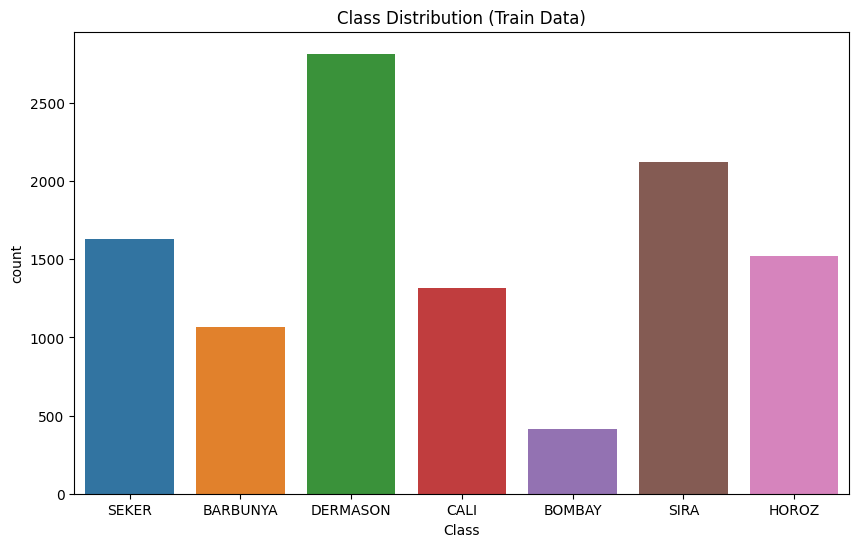

Missing values train data:
Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
dtype: int64
Missing values test data:
Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
dtype: int64


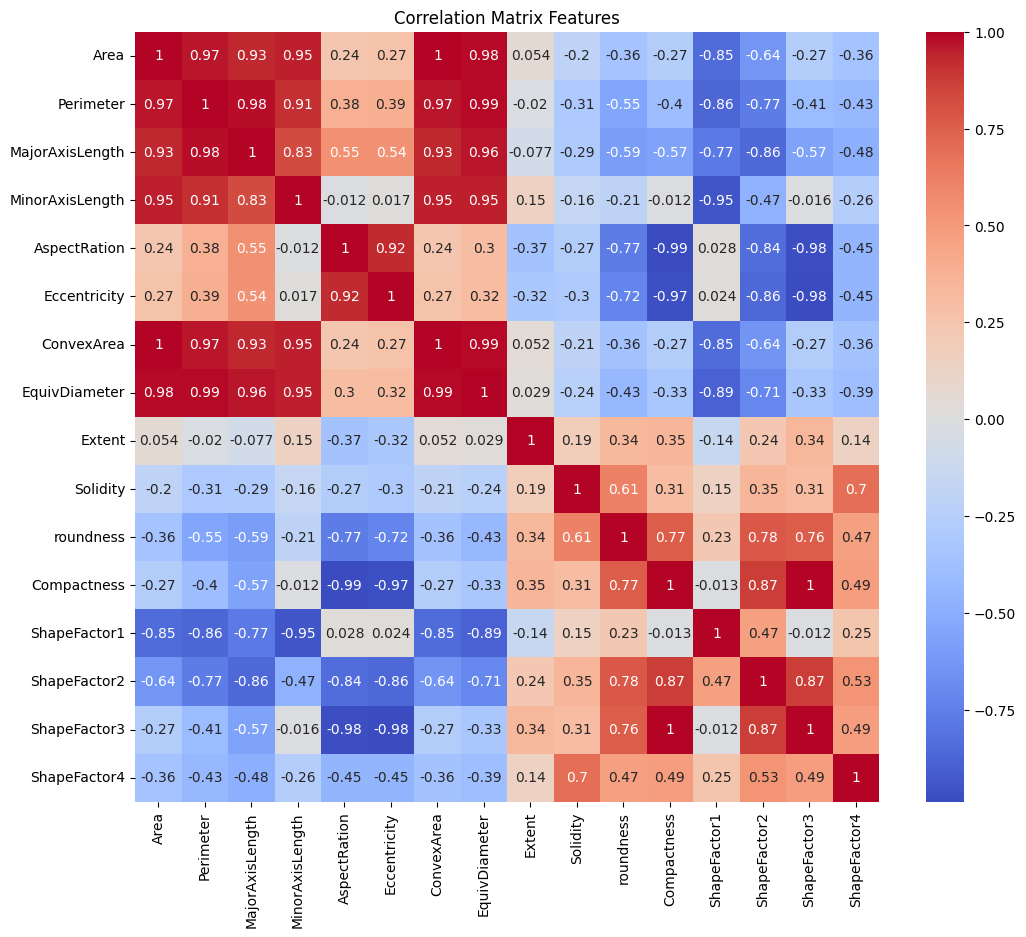

In [220]:

drybean = DataLoader('/kaggle/input/dry-bean/dry_bean_classification_train.csv','/kaggle/input/dry-bean/dry_bean_classification_test.csv')
drybean.print_data_info()
target_col = drybean.get_target_column()
drybean.split_data(target_col)


feature = DataPreprocessor(drybean.X_train, drybean.y_train, drybean.X_test, drybean.y_test, drybean.train_data)
feature.encode_labels()
feature.print_class_distribution()
feature.visualize_class_distribution(target_col)
feature.check_missing_values()
feature.plot_correlation_matrix()

    

Performing SMOTE

Class distribution after SMOTE oversampling:
5    2815
0    2815
3    2815
2    2815
1    2815
6    2815
4    2815
Name: count, dtype: int64


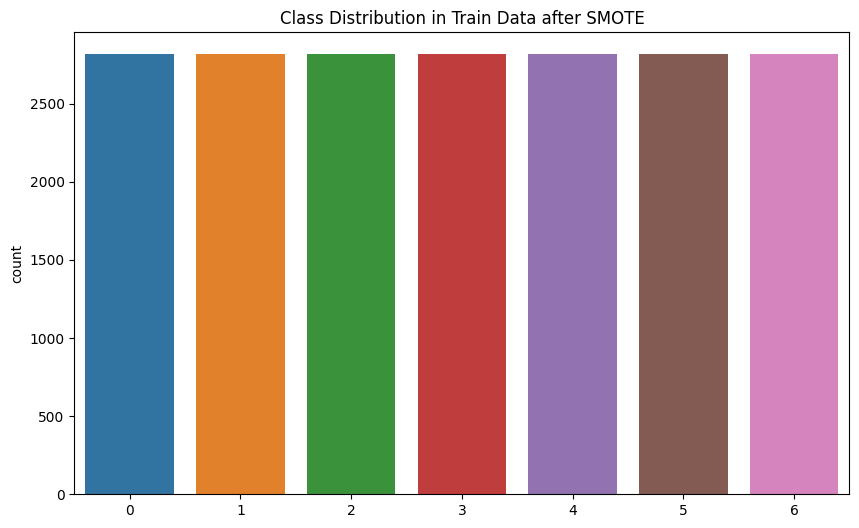

In [221]:
feature.oversample_smote()
feature.visualize_smote_distribution()


Visualizing the numerical distrbutions of all features:

Numerical Features:
                Area     Perimeter  MajorAxisLength  MinorAxisLength  \
count   10889.000000  10889.000000     10889.000000     10889.000000   
mean    53037.428965    855.112602       319.933861       202.383737   
std     29305.978236    213.927855        85.515726        44.974352   
min     20420.000000    524.736000       183.601165       122.512653   
25%     36325.000000    703.597000       253.331461       175.931143   
50%     44665.000000    795.057000       296.875317       192.626917   
75%     61377.000000    976.350000       375.980183       217.434281   
max    254616.000000   1985.370000       738.860154       450.926187   

       AspectRation  Eccentricity     ConvexArea  EquivDiameter        Extent  \
count  10889.000000  10889.000000   10889.000000   10889.000000  10889.000000   
mean       1.581485      0.750187   53757.716319     253.054062      0.749741   
std        0.246503      0.092504   29760.311469      59.104266      0.048717   
min    

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

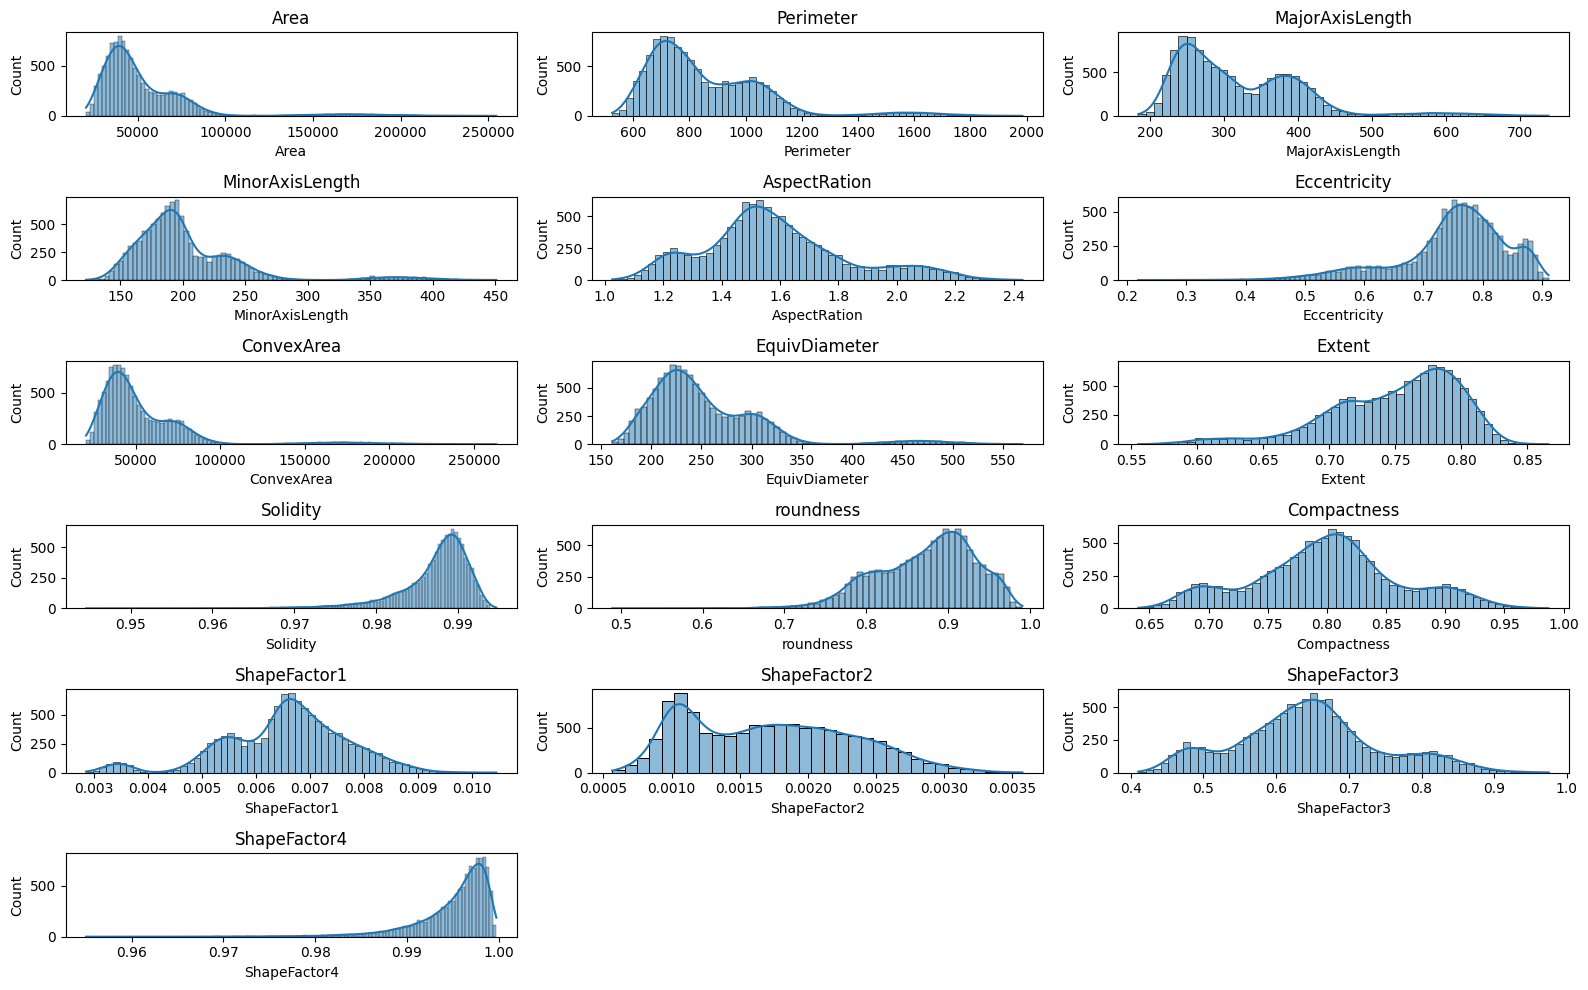

In [222]:
feature.print_numerical_statistics()
feature.visualize_numerical_distributions()


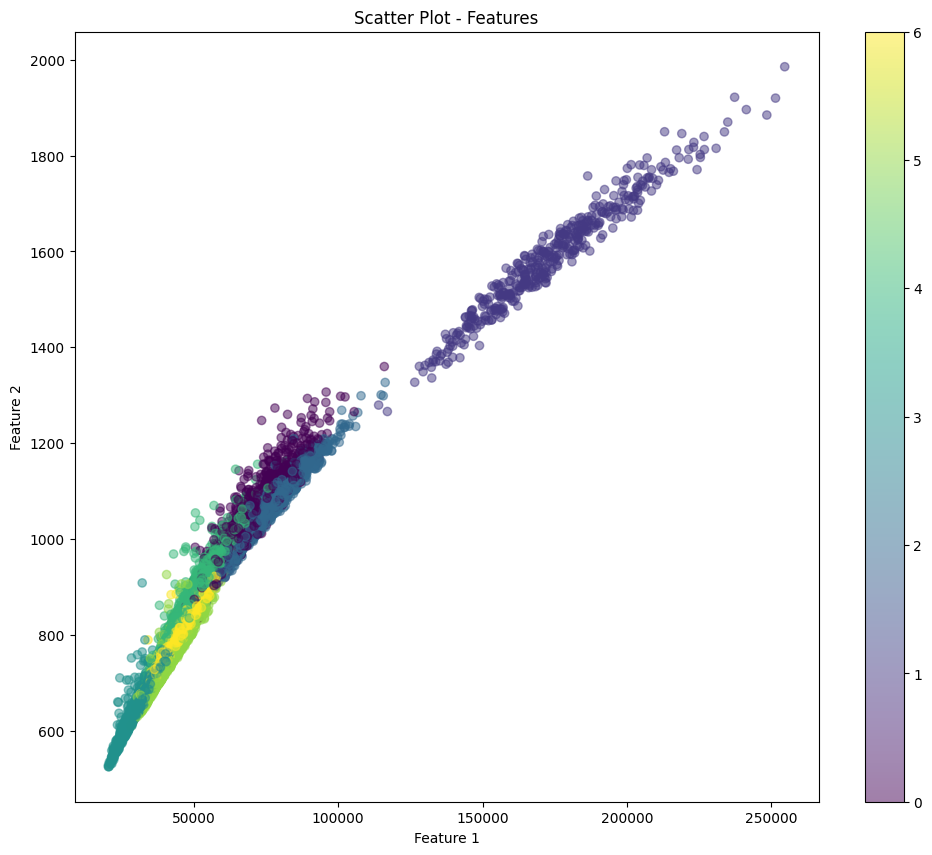

In [223]:
#Scatter plot before processing of data
feature.visualize_original_scatter(target_col)


Data Augmentaion and scaling is done,Also the outliers are removed:

In [224]:
feature.scale_data()
feature.augment_data()
feature.remove_outliers()

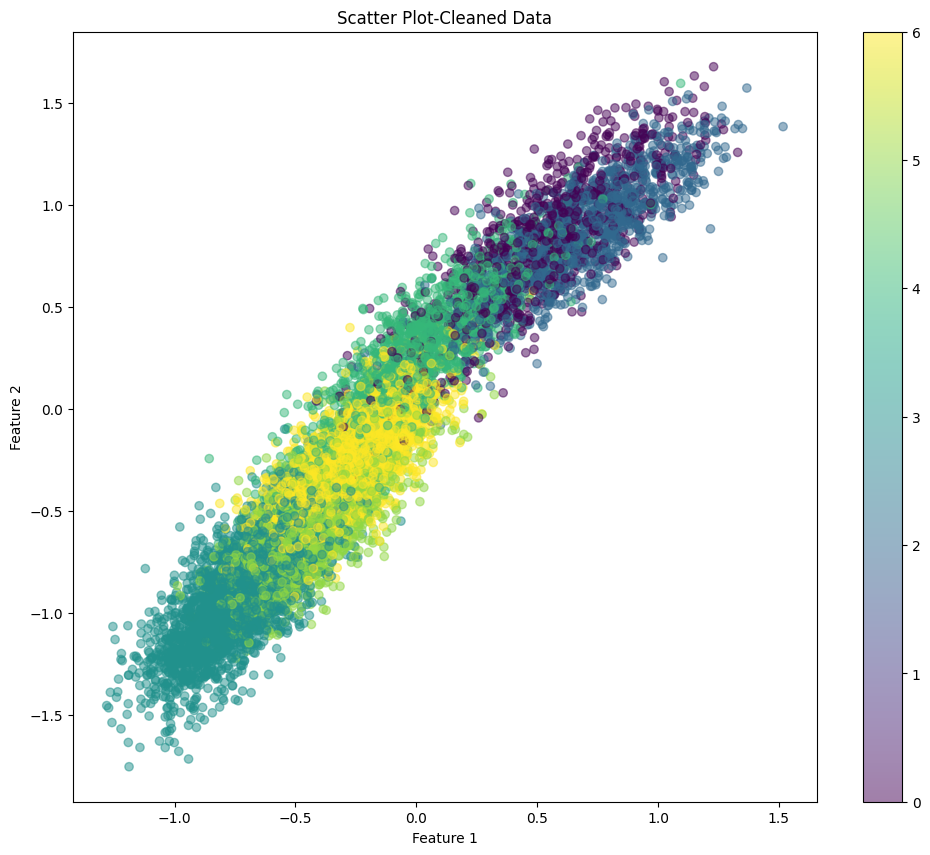

In [225]:
feature.visualize_cleaned_scatter()

Feature engineering and selection is carried out:


In [226]:
feature.polynomial_features()
feature.select_features()
feature.encode_categorical_features()


PCA:

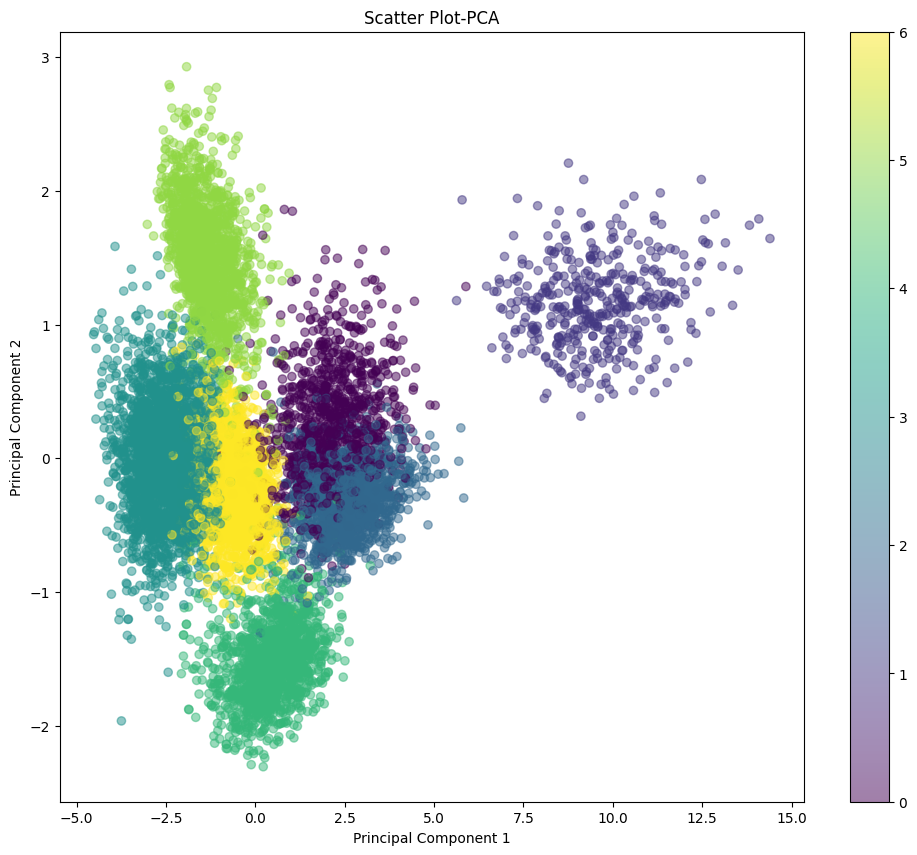

In [227]:
feature.apply_pca()

feature.visualize_pca_scatter()

Trivial model is trained:

In [228]:

trivial = TrivialSystem(feature.y_train, feature.y_test)
trivial.predict()
trivial.evaluate_train()



Training- Trivial System:
Accuracy: 0.168
Macroaveraged F1 score: 0.140
Microaveraged F1 score: 0.168


Baseline model is trained:

In [229]:

baseline = BaselineSystem(feature.X_train_pca, feature.y_train)
baseline.split_data()
baseline.train()
baseline.predict_train()
baseline.evaluate_train()
baseline.predict_val()
baseline.evaluate_val()
y_baseline = baseline.predict_test(feature.X_test_pca)


Training- Baseline :
Accuracy: 0.895
Macroavg F1score: 0.883
Microavg F1score: 0.895

Validation- Baseline :
Accuracy: 0.881
Macroavg F1score: 0.869
Microavg F1score: 0.881


Artificial Neural Network with 500 layers and 100 max_iterations is trained:

In [230]:

ann = ArtificialNeuralNetwork(feature.X_train_pca, feature.y_train)
ann.split_data()
ann.train()
ann.predict_train()
ann.evaluate_train()
ann.predict_val()
ann.evaluate_val()
y_mlp = ann.predict_test(feature.X_test_pca)



Training- ANN:
Accuracy: 0.969
Macroavg F1score: 0.958
Microavg F1score: 0.969

Validation- ANN:
Accuracy: 0.959
Macro-avg F1score: 0.947
Micro-avg F1score: 0.959


Random Forest model is trained:

In [231]:

rf = RandomForestClassifier(feature.X_train_pca, feature.y_train)
rf.split_data()
rf.train()
rf.predict_train()
rf.evaluate_train()
rf.predict_val()
rf.evaluate_val()
y_rf = rf.predict_test(feature.X_test_pca)



Training- Random Forest:
Accuracy: 0.971
Macroavg F1score: 0.961
Microavg F1score: 0.971

Validation- Random Forest:
Accuracy: 0.956
Macroavg F1score: 0.946
Microavg F1score: 0.956


KNearest Neighbhors trained:

In [232]:

knn = KNearestNeighborsClassifier(feature.X_train_pca, feature.y_train)
knn.split_data()
knn.train()
knn.predict_train()
knn.evaluate_train()
knn.predict_val()
knn.evaluate_val()
y_knn = knn.predict_test(feature.X_test_pca)


Training-  KNearest Neighbors:
Accuracy: 0.969
Macroavg F1score: 0.959
Microavg F1score: 0.969

Validation-  KNearest Neighbors:
Accuracy: 0.945
Macroavg F1score: 0.932
Microavg F1score: 0.945


SVM trained:

In [233]:

svm = SupportVectorMachine(feature.X_train_pca, feature.y_train)
svm.split_data()
svm.train()
svm.predict_train()
svm.evaluate_train()
svm.predict_val()
svm.evaluate_val()
y_svc = svm.predict_test(feature.X_test_pca)


Training Performance Support Vector Machine:
Accuracy: 0.960
Macro-averaged F1 score: 0.948
Micro-averaged F1 score: 0.960

Validation Performance Support Vector Machine:
Accuracy: 0.954
Macro-averaged F1 score: 0.943
Micro-averaged F1 score: 0.954


Cross validation fro training data and for validation data of picked models is performed:

In [234]:

cross_validation = CrossValidation(feature.X_train_sm, feature.y_train_sm, feature.X_test_pca, feature.y_test)
models = {
'Random Forest': rf.rf,
'KNN': knn.knn,
}
cv_scores = cross_validation.cross_validate_and_predict(models)



Crossvalidation scores (Random Forest):
Train : Mean=0.960, Std=0.001
Validation : Mean=0.945, Std=0.004

Crossvalidation scores (KNN):
Train : Mean=0.880, Std=0.001
Validation : Mean=0.813, Std=0.008


Performance metrics:

In [235]:

perf = PerformanceEvaluation(feature.y_test, trivial.y_trivial, y_baseline, y_mlp, y_rf, y_knn, y_svc)
perf.print_accuracy()
perf.print_f1_scores()
perf.print_confusion_matrices()


Classification Accuracy:

Trivial : 0.175
Baseline : 0.893
Artificial Neural Network: 0.970
Random Forest: 0.964
KNearest Neighbors: 0.956
Support Vector Machine: 0.964

F1scores:

Macroavg F1 score:
Trivial : 0.145
Baseline : 0.878
Artificial Neural Network: 0.959
Random Forest: 0.952
KNearest Neighbors: 0.942
Support Vector Machine: 0.952

Microavg F1 score:
Trivial : 0.175
Baseline System: 0.893
Artificial Neural Network: 0.970
Random Forest: 0.964
KNearest Neighbors: 0.956
Support Vector Machine: 0.964

Confusion Matrices:

Trivial :
 [[ 23   8  31  62  35  40  55]
 [  9   6  16  22  14  22  19]
 [ 42  19  40  67  43  34  69]
 [ 64  33  78 190 115 109 142]
 [ 40  24  53 103  57  60  69]
 [ 41  11  40 110  55  55  84]
 [ 33  21  71 139  65  80 104]]
Baseline System:
 [[146   0  81   0   3   2  22]
 [  0 108   0   0   0   0   0]
 [ 51   0 254   0   7   0   2]
 [  0   0   0 688   0   3  40]
 [  0   0  21   1 369   0  15]
 [  1   0   0   0   0 375  20]
 [  0   0   0   6  15   2 490]]
A

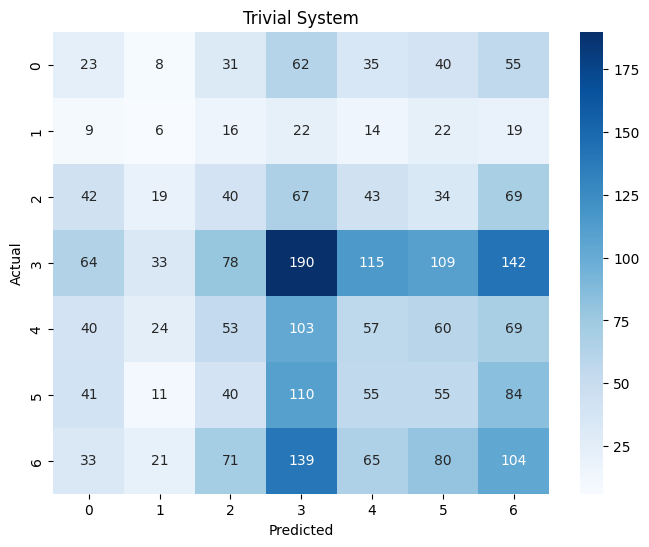

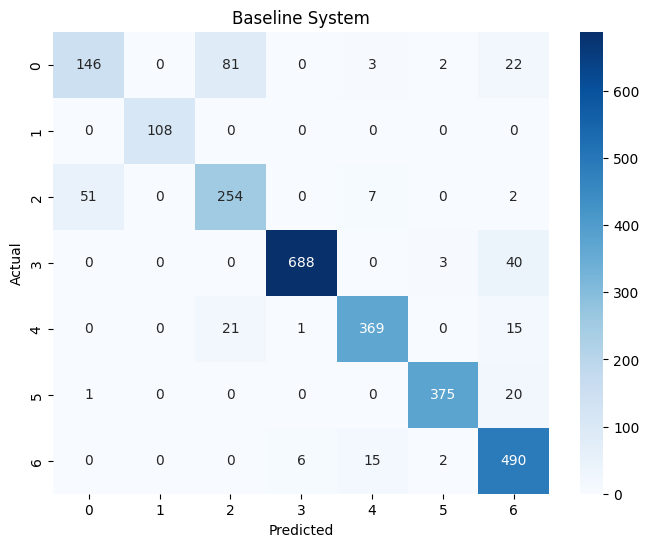

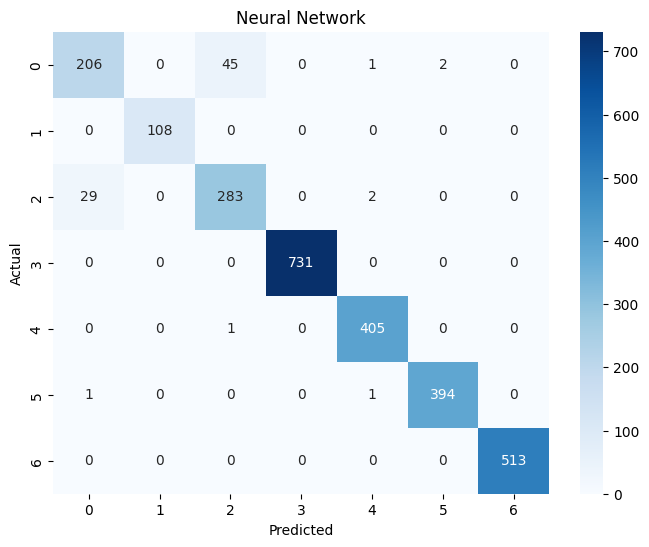

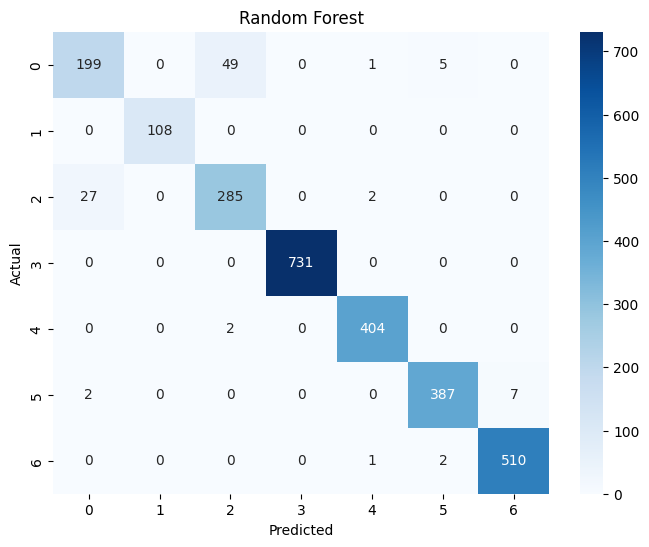

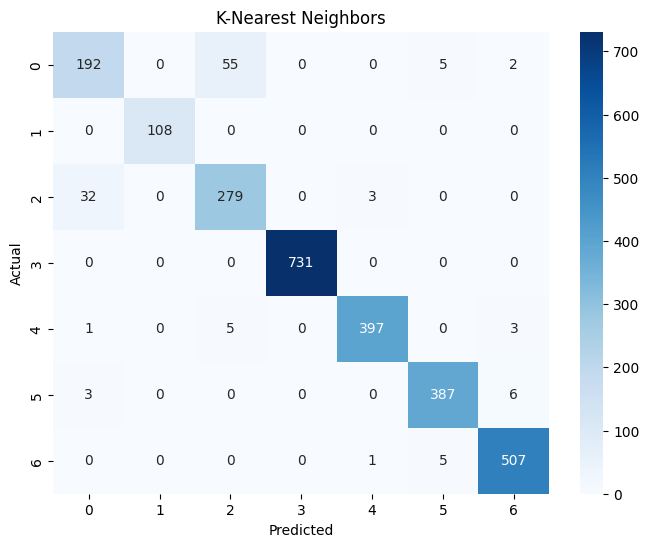

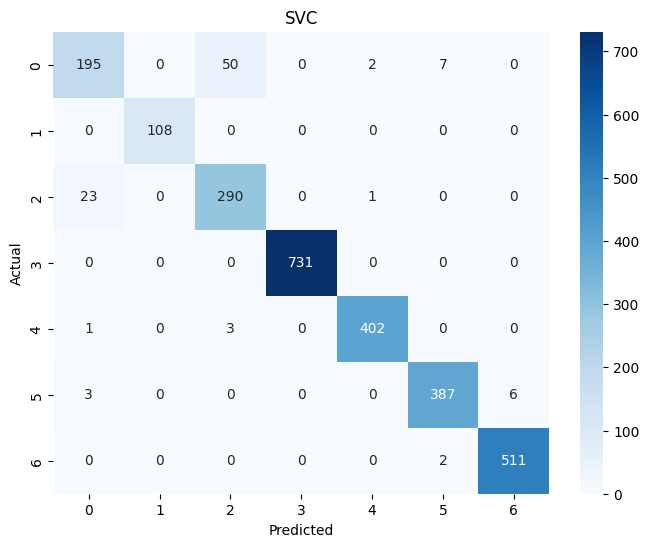

In [236]:

plot_confusion_matrix(feature.y_test, trivial.y_trivial, 'Trivial System')
plot_confusion_matrix(feature.y_test, y_baseline, 'Baseline System')
plot_confusion_matrix(feature.y_test, y_mlp, 'Neural Network')
plot_confusion_matrix(feature.y_test, y_rf, 'Random Forest')
plot_confusion_matrix(feature.y_test, y_knn, 'K-Nearest Neighbors')
plot_confusion_matrix(feature.y_test, y_svc, 'SVC')